## Setup
This notebook trains and evaluates a ***CNN*** on a preprocessed ***rock image dataset***.
The dataset was prepared locally and uploaded in train/test format.


In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset upload check
Verify that the zipped dataset has been uploaded correctly before extraction.


In [2]:
import zipfile
from pathlib import Path

data_path = Path("data.zip")

print("Exists:", data_path.exists())
print("Size:", data_path.stat().st_size)
print("Is zip:", zipfile.is_zipfile(data_path))


Exists: True
Size: 111525839
Is zip: True


## Dataset extraction
Unzip the prepared dataset if it has not been extracted yet.


In [3]:
data_path = Path("data.zip")
dataset = Path("dataset")
if dataset.is_dir():
  print("Already exists, skipping extraction")

else:
  print("Extracting.....")
  with zipfile.ZipFile(data_path, "r") as zip_ref:
    zip_ref.extractall("dataset")

Already exists, skipping extraction


## Dataset structure check
Verify the extracted dataset structure and file counts.


In [4]:
# Checking data
import os

for dirpath, dirnames, filenames in os.walk(dataset):
    print(f"There are {len(dirnames)} directories in {dirpath}, {len(filenames)} images.")


There are 2 directories in dataset, 0 images.
There are 7 directories in dataset/train, 0 images.
There are 0 directories in dataset/train/Quartzite, 381 images.
There are 0 directories in dataset/train/Sandstone, 260 images.
There are 0 directories in dataset/train/Granite, 80 images.
There are 0 directories in dataset/train/Coal, 295 images.
There are 0 directories in dataset/train/Basalt, 68 images.
There are 0 directories in dataset/train/Limestone, 270 images.
There are 0 directories in dataset/train/Marble, 309 images.
There are 7 directories in dataset/test, 0 images.
There are 0 directories in dataset/test/Quartzite, 96 images.
There are 0 directories in dataset/test/Sandstone, 65 images.
There are 0 directories in dataset/test/Granite, 21 images.
There are 0 directories in dataset/test/Coal, 74 images.
There are 0 directories in dataset/test/Basalt, 18 images.
There are 0 directories in dataset/test/Limestone, 68 images.
There are 0 directories in dataset/test/Marble, 78 image

## Exploratory data check
Random samples from the training set to verify labels and image quality.


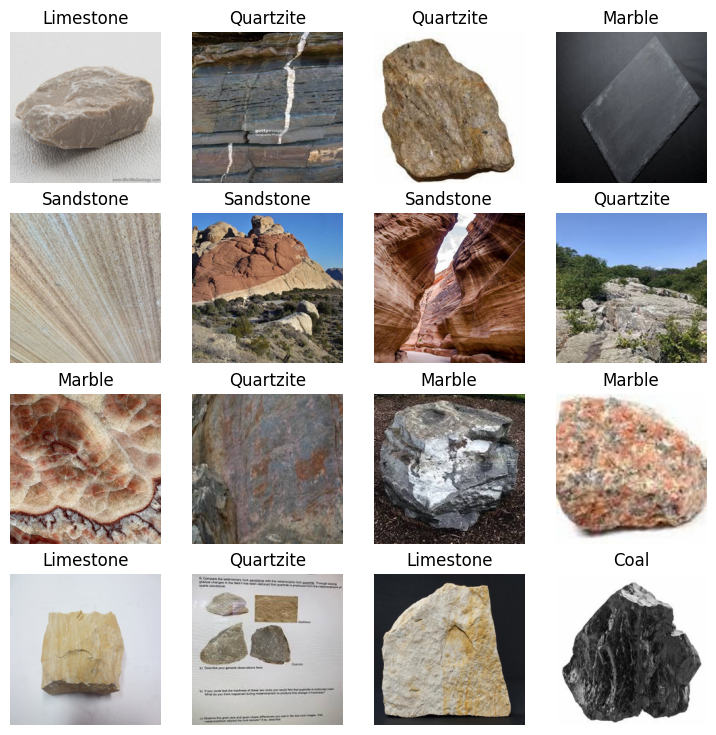

In [5]:
# Randomly displaying images
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(42)
dataset = Path("dataset")

train_path = dataset / "train"
train_images = list(train_path.rglob("*.jpg"))

n_samples= 16
random_images = random.sample(train_images, k=n_samples) # Taking random samples
random_image_class = []
for file in random_images: # Taking random samples class names
  cls_name = file.parent.name
  random_image_class.append(cls_name)

arrays = []

for img in random_images: # Converting images into numpy arrays

    with Image.open(img) as img_pil:

      img_pil = img_pil.resize((224, 224))
      img_pil = img_pil.convert("RGB")
      arr = np.array(img_pil, dtype=np.float32) / 256.0
      arrays.append(arr)

random_images_numpy = np.stack(arrays)

fig = plt.figure(figsize=(9,9)) # Plotting random images
for i, img in  enumerate(random_images_numpy, start = 1):
  ax = fig.add_subplot(4,4,i)
  ax.imshow(img)
  ax.set_title(random_image_class[i-1])
  ax.axis("off")

## Dataset and transforms
Torchvision utilities for image preprocessing and dataset loading.


In [6]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

## Image transforms & Dataset loading
Preprocessing and data augmentation,
load training and test datasets using ImageFolder.



In [7]:
# Train transform (includes augmentation)
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Test transform (no random augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_path = dataset / "train"
test_path  = dataset / "test"

train_data = ImageFolder(root=train_path, transform=train_transform)
test_data  = ImageFolder(root=test_path,  transform=test_transform)

print(f"Class names = {train_data.classes}")
print(f"{len(train_data)} train data & {len(test_data)} test data")

Class names = ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']
1663 train data & 420 test data


## Effect of preprocessing
Comparison of raw images and images after applying training transforms.



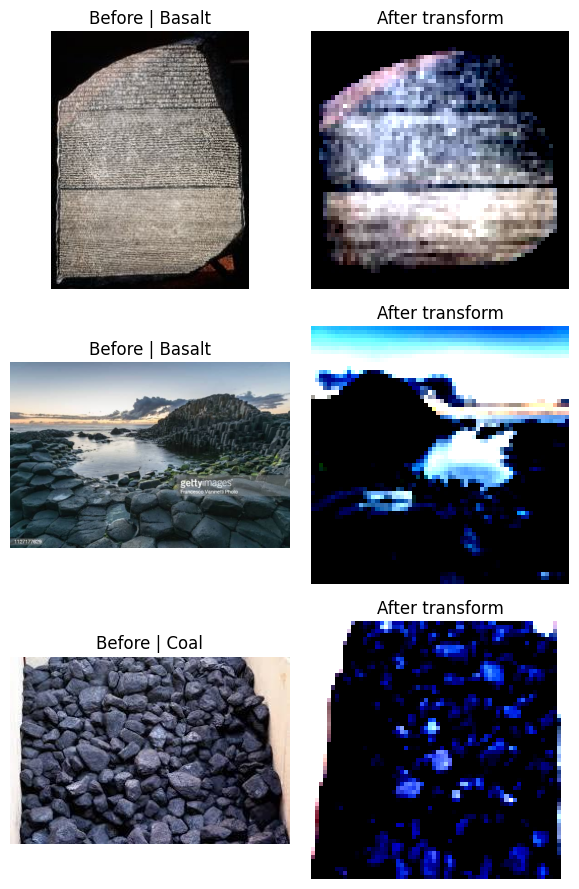

In [8]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# pick 3 random indices
idxs = random.sample(range(len(train_data)), 3)

fig, axes = plt.subplots(len(idxs), 2, figsize=(6, 3*len(idxs)))

for row, idx in enumerate(idxs):
    path, label = train_data.samples[idx]  # (filepath, class_index)

    # BEFORE: raw PIL
    pil_img = Image.open(path).convert("RGB")
    axes[row, 0].imshow(pil_img)
    axes[row, 0].set_title(f"Before | {train_data.classes[label]}")
    axes[row, 0].axis("off")

    # AFTER: apply same transform used in ImageFolder
    x = train_data.transform(pil_img)  # tensor (C,H,W), float in [0,1]
    axes[row, 1].imshow(x.permute(1, 2, 0).numpy())
    axes[row, 1].set_title("After transform")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()


## DataLoaders
Create batched data loaders for training and testing.


In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)


torch.Size([32, 3, 64, 64]) torch.Size([32])


In [10]:
import torch
from torch import nn

class RockClassifier(nn.Module):
      def __init__(self, input_shape : int, hidden_units : int, output_shape :int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units, kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3), padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # For 64x64 input: after conv/pool blocks feature map is (hidden_units, 15, 15)
            nn.Linear(in_features=hidden_units*15*15,out_features=output_shape)
            )



      def forward(self,x):
          x = self.block_1(x)
          x = self.block_2(x)
          x = self.classifier(x)
          return x

torch.manual_seed(42)
model = RockClassifier(input_shape=3, hidden_units=32, output_shape=len(train_data.classes))
model.to(device)



RockClassifier(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7200, out_features=7, bias=True)
  )
)

In [11]:
X, _ = next(iter(train_dataloader))
X = X.to(device)
with torch.inference_mode():
    out = model.block_2(model.block_1(X))
print(out.shape)  # should be [batch, 32, 15, 15]


torch.Size([32, 32, 15, 15])


Defining loss function, optimizer and accuracy function

In [12]:
def accuracy_fn(y_true, y_pred):
  '''
  Calculates accuracy between true labels and predicted labels.
  Args:
    y_true : tensor of true labels
    y_pred : tensor of predicted labels
  Return:
    Accuracy percentage
  '''
  corrects = torch.eq(y_pred, y_true).sum().item()
  acc = (corrects/len(y_pred))*100
  return acc

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Defining execution time


In [13]:
from timeit import default_timer as timer
def execution_time(start : float, end : float):
  total_time = end-start
  print(f"Total time {total_time:.4f} seconds")


Training loop


In [14]:
import torch
from torch import nn
def train_step(model: nn.Module,
               dataloader : DataLoader,
               loss_fn : nn.Module,
               accuracy_fn,
               optimizer : torch.optim.Optimizer,
               device : torch.device
              ):

    model.train()
    train_loss, train_acc =0,0
    for X,y in dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = torch.argmax(y_logits, dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y,y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy is computed per batch and averaged across batches
        train_loss+=loss.item()
        train_acc+=acc

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Average of train loss : {train_loss}, Train accuracy : {train_acc:.2f}")


Testing loop

In [15]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              device : torch.device):

    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            y_pred = torch.argmax(logits, dim=1)
            test_acc += acc_fn(y, y_pred)

    test_loss /= len(dataloader)
    test_acc  /= len(dataloader)

    print(f"Average of test loss : {test_loss} | Test accuracy : {test_acc:.2f}")


In [16]:
from tqdm.auto import tqdm
train_start = timer()

epochs = 4
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch+1}/{epochs}--------")
  train_step(model=model,
             dataloader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)


  test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=accuracy_fn, device=device)

  if epoch == 1:
    torch.save(model.state_dict(), "rock_classifier_best.pth")

train_end = timer()
execution_time(start=train_start, end=train_end)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4--------
Average of train loss : 1.5920133567773378, Train accuracy : 38.78
Average of test loss : 1.3577909937926702 | Test accuracy : 48.66
Epoch 2/4--------
Average of train loss : 1.388732522726059, Train accuracy : 47.69
Average of test loss : 1.2542318808180946 | Test accuracy : 56.70
Epoch 3/4--------
Average of train loss : 1.3380455076694489, Train accuracy : 50.99
Average of test loss : 1.3093988341944558 | Test accuracy : 50.45
Epoch 4/4--------
Average of train loss : 1.2924421441096525, Train accuracy : 51.84
Average of test loss : 1.2679837856973921 | Test accuracy : 49.11
Total time 44.9395 seconds


In [17]:
## Collect predictions on test set
y_pred = []
y_true = []

model.eval()
with torch.inference_mode():

    for X, y in test_dataloader:

        X, y =X.to(device), y.to(device)
        logits = model(X)
        pred = torch.argmax(logits, dim = 1)

        y_pred.extend(pred.cpu().numpy())
        y_true.extend(y.cpu().numpy())


y_pred = np.array(y_pred)
y_true = np.array(y_true)


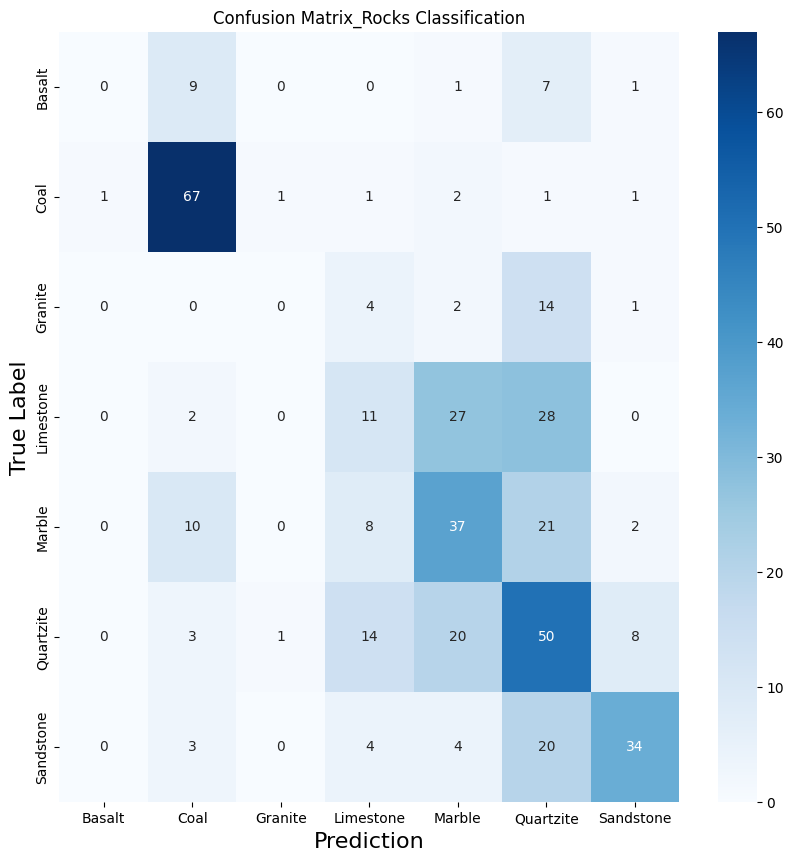

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = list(train_data.classes)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True,fmt='d',
            cmap='Blues',
            xticklabels=class_names
            , yticklabels=class_names)
plt.xlabel('Prediction', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title("Confusion Matrix_Rocks Classification")
plt.show()


The model performs well on visually distinctive rock types (Coal, Sandstone, Quartzite) while struggling with geologically and visually similar classes (Limestone, Marble, Granite), highlighting the limits of texture-only features in fine-grained rock classification.

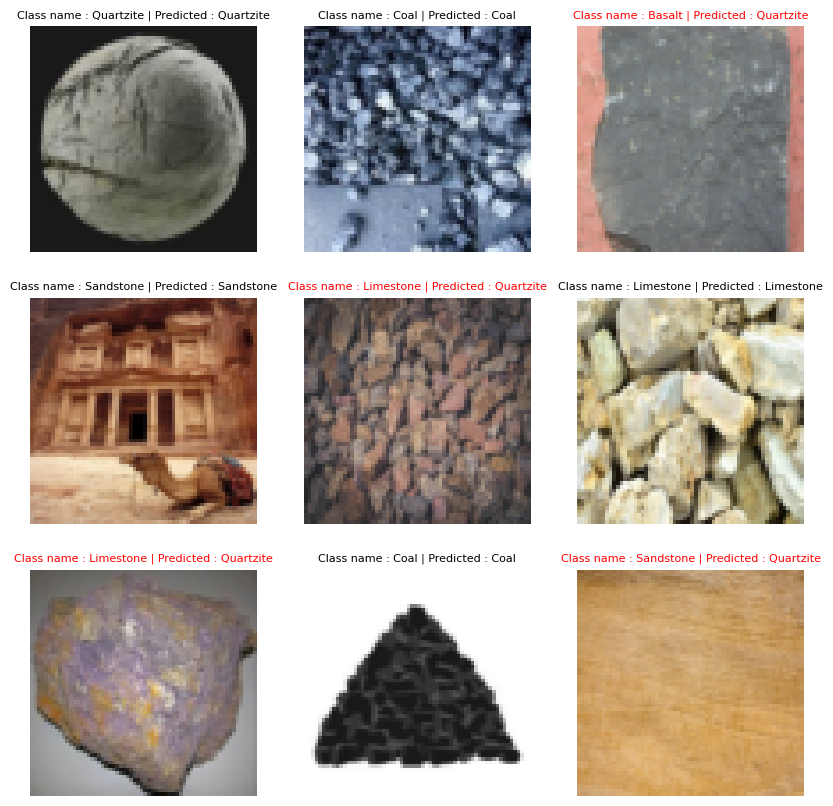

In [19]:
import random
import matplotlib.pyplot as plt

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

class_names = test_data.classes
random.seed(42)
indices = random.sample(range(len(test_data)), 9)

plt.figure(figsize=(10,10))
for i, idx in enumerate(indices,start=1):
  plt.subplot(3,3,i)
  img, label = test_data[idx]


  img = img * std + mean          # undo Normalize

  plt.imshow(img.permute(1,2,0))
  plt.axis("off")
  if y_pred[idx] == y_true[idx]:
    plt.title(f"Class name : {class_names[y_true[idx]]} | Predicted : {class_names[y_pred[idx]]}", fontsize=8)
  else:
    plt.title(f"Class name : {class_names[y_true[idx]]} | Predicted : {class_names[y_pred[idx]]}", fontsize=8, color='r')


